In [42]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool

from definitions import ROOT_DIR
from unc.utils import load_info, get_discounted_returns, average_returns_over_last, map_discounted_returns_to_steps

In [43]:
r_color = 'black'
r_lstm_color = 'blue'
rpg_color = 'darkorange'
rsg_color = 'forestgreen'

all_paths = {
    'rg': Path(ROOT_DIR, 'results', 'rs_hs_unc', 'rg'),
    'rg_lstm':  Path(ROOT_DIR, 'results', 'rs_hs_unc', 'rg_lstm'),
    'rpg': Path(ROOT_DIR, 'results', 'rs_hs_unc', 'rpg'),
    'rxg': Path(ROOT_DIR, 'results', 'rs_hs_unc', 'rxg'),
    'rsg': Path(ROOT_DIR, 'results', 'rs_hs_unc', 'rsg')
}
plot_info = {
    'rg': {'color': f_color, 'label': 'f: Normal obs, |o| = 5'},
    'rg_lstm':  {'color': f_lstm_color, 'label': 'f_lstm: LSTM + Normal obs w/ buffer, |o| = 5'},
    'rg_lstm_cat':  {'color': 'red', 'label': 'LSTM + additive action conditioning, |o| = 5 + 3'},
    'rg_lstm_hs_unc':  {'color': 'gray', 'label': 'LSTM + hidden state uncertainty, |o| = 5'},
    'rg_lstm_cat_hs_unc':  {'color': 'lightgray', 'label': 'LSTM + action cond + hidden state uncertainty, |o| = 5 + 3'},
    'fpg': {'color': fpg_color, 'label': 'fpg: PF obs, |o| = 196 + 5'},
    'fsg': {'color': fsg_color, 'label': 'fsg: Ground-truth obs, |o| = 196 + 5'}
}
split_by = ['buffer_size', 'step_size', 'algo', 'trunc', 'arch', 'value_step_size', 'action_cond', 'k_rnn_hs', 'init_hidden_var']
Args = namedtuple('args', split_by)





In [44]:
def process_dir(dir_path, split_by, w=100, discount=0.99):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        info = load_info(f)
        args = info['args'].item()
        if "value_step_size" not in args:
            args['value_step_size'] = 0.0001
        if "arch" not in args:
            args['arch'] = 'nn'
        if "k_rnn_hs" not in args:
            args['k_rnn_hs'] = 1
        if "action_cond" not in args:
            args['action_cond'] = None
        if "init_hidden_var" not in args:
            args['init_hidden_var'] = 0.1
            
        result = get_discounted_returns(info['episode_length'], info['reward'], discount)

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((info['episode_length'], result, args))

    
    return all_results


In [45]:
discount = 0.9
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by, discount=discount)
    raw_data[key] = processed

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [46]:
def group_by_multiple(dataset, keys_to_labels, split_file):
    grouped_data = {}
    for args, d in dataset.items():
        label = split_file[:]
        for key, key_map in keys_to_labels.items():
            val = getattr(args, key)
            if key_map[val] is not None:
                label += f"_{key_map[val]}"
        if label not in grouped_data:
            grouped_data[label] = {}
        
        grouped_data[label][args] = d
    return grouped_data

In [47]:
keys_to_label_map = {
    'action_cond': {None: None, 'cat': 'cat'}, 
    'k_rnn_hs': {1: None, 10: 'hs_unc'}
}
split_file = 'f_lstm'
action_cond_grouped = group_by_multiple(raw_data[split_file], keys_to_label_map, split_file)

In [48]:
new_raw = {}
for k, v in action_cond_grouped.items():
    new_raw[k] = v

for k, v in raw_data.items():
    if k != "f_lstm":
        new_raw[k] = v

In [49]:
eps_max_over = 100
all_max_over = {}
for key, v in new_raw.items():
    all_max_over[key] = average_returns_over_last(v, eps_max_over)

In [51]:
# Get the best hyperparams based on the final 100 episodes
all_best = {}
for key, v in all_max_over.items():
    all_best[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best

{'f_lstm_hs_unc': (args(buffer_size=10000, step_size=0.0001, algo='sarsa', trunc=10, arch='lstm', value_step_size=0.0005, action_cond=None, k_rnn_hs=10, init_hidden_var=0.5),
  0.1365258),
 'f_lstm_cat_hs_unc': (args(buffer_size=100000, step_size=0.001, algo='sarsa', trunc=10, arch='lstm', value_step_size=0.0005, action_cond='cat', k_rnn_hs=10, init_hidden_var=0.1),
  0.2809937),
 'f_lstm_cat': (args(buffer_size=100000, step_size=0.001, algo='sarsa', trunc=20, arch='lstm', value_step_size=0.0001, action_cond='cat', k_rnn_hs=1, init_hidden_var=0.1),
  0.28555664),
 'f_lstm': (args(buffer_size=100000, step_size=1e-05, algo='sarsa', trunc=10, arch='lstm', value_step_size=0.0001, action_cond=None, k_rnn_hs=1, init_hidden_var=0.1),
  0.19611546),
 'f': (args(buffer_size=10000, step_size=0.0001, algo='sarsa', trunc=0, arch='nn', value_step_size=0.0001, action_cond=None, k_rnn_hs=1, init_hidden_var=0.1),
  0.0287962),
 'fpg': (args(buffer_size=10000, step_size=0.001, algo='sarsa', trunc=0, ar

In [52]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode



In [55]:
trunc = int(1e6)
all_mapped_data = {}
for key, v in all_best.items():
    arg = v[0]
    all_mapped_data[key] = map_discounted_returns_to_steps(new_raw[key][arg], trunc=trunc)

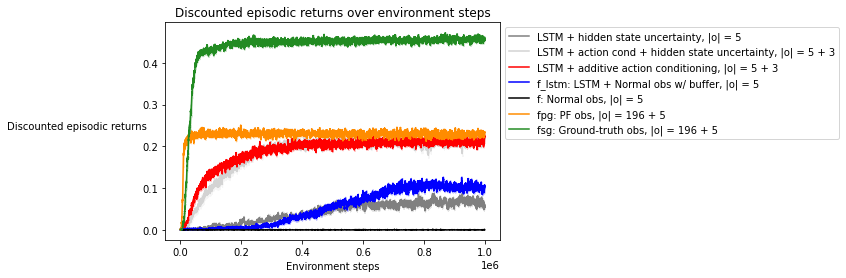

In [56]:
fig, ax = plt.figure(), plt.axes()


for k, v in all_mapped_data.items():
    data = v
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1])

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
ax.set_title(f'Discounted episodic returns over environment steps')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')


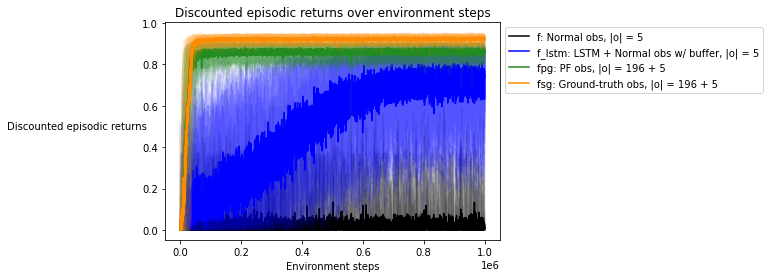

In [148]:
# Here we do individual plots and no std errors
fig, ax = plt.figure(), plt.axes()

for k, v in all_mapped_data.items():
    data = v
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1])    
    for d in data:
        ax.plot(x, d, color=color, alpha=0.1)
    means = data.mean(axis=0)

    ax.plot(x, means, label=key, color=color)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
ax.set_title(f'Discounted episodic returns over environment steps')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [37]:
# Now for RPG q-learning vs esarsa vs sarsa plots
def group_by(dataset, key):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        if key_val not in grouped_data:
            grouped_data[key_val] = {}
        
        grouped_data[key_val][args] = d
    return grouped_data

In [38]:
key = 'algo'
rpg_grouped_alg = group_by(rpg_data, key)

In [39]:
rpg_algo_max_overs = {}
for algo, d in rpg_grouped_alg.items():
    rpg_algo_max_overs[algo] = get_eps_max_over(d, eps_max_over=100)

In [40]:
rpg_algo_maxes = {}
for algo, d in rpg_algo_max_overs.items():
    rpg_algo_maxes[algo] = sorted(d, key=lambda x : x[1], reverse=True)[0]

In [42]:
mapped_rpg_algo_data = {}
for alg, (hparams, _) in rpg_algo_maxes.items():
    mapped_rpg_algo_data[alg] = map_dis_rew_to_steps(rpg_grouped_alg[alg][hparams], trunc=trunc)

In [43]:
plot_params = {
    'esarsa': {'color': 'orange'},
    'qlearning': {'color': 'blue'},
    'sarsa': {'color': 'red'}
              }

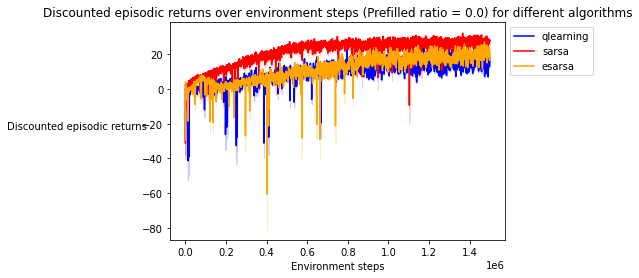

In [44]:
x_alg = np.arange(mapped_rpg_algo_data['sarsa'].shape[1])
alg_fig, alg_ax = plt.figure(), plt.axes()


for key, data in mapped_rpg_algo_data.items():
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    alg_ax.plot(x_alg, means, label=key, color=plot_params[key]['color'])
    plt.fill_between(x_alg, means - std_err, means + std_err,
                         color=plot_params[key]['color'], alpha=0.2)

alg_ax.set_xlabel('Environment steps')
alg_ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
alg_ax.set_title(f'Discounted episodic returns over environment steps (Prefilled ratio = 0.0) for different algorithms')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
